# Fake News SOS!!

Name: 黃名儀, 施瑋昱

Department: 資訊管理學系碩一

Student ID: 111356047, 111356051


## Problems Definition

在當今數位時代，假新聞的氾濫成災，而ChatGPT的問世更加速了虛假資訊的蔓延。面對廣大民眾普遍缺乏媒體識讀能力的現狀，個人往往因群眾效應而信以為真，無意中助長了誤導性貼文和文章的傳播。這對我們的資訊安全構成了嚴重威脅。以川普在競選美國總統前散播虛假消息的案例為例，他企圖操縱或干涉選舉，使我們意識到區分真假新聞的重要性。

為了建立更健全的網路生態系統，我們需要針對假新聞進行技術性對抗。資訊安全領域需要不斷改進偵測和驗證技術，以辨識假新聞的特徵和模式。透過機器學習、自然語言處理和數據分析等技術手段，我們能夠自動化假新聞的辨識和分類，提供精準的警示和評估。此外，建立健全的數位驗證機制，包括數位簽章和可信任的資料來源追溯，能夠有效抵制假新聞的散布。



* 透過這個數據集，我們想知道從這些columns 中，哪些是可以分類是否為假新聞的重要因子。
* 哪種模型分類效果最好。
* word embedding後，用幾維的向量分類效果好。



## Our DataSet
來源:[Fake and real news dataset
](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)

## Our Model

**Pre-processing**


* 我們將Date(年、月、日)資料拆分成三個columns
* 將Date資料不符合(年、月、日)的data刪除
* 分析哪個時間點假新聞的數目較多
* 計算真假新聞的總數，看其分佈均不均勻
* 將文本資料用Data Cloud的方式呈現，觀察真和假兩種新聞中，分別是哪些字眼特別常出現
* subject欄位做one-hot encoding
* 統計每個文本的長度
* 資料中有title和text兩個文本欄位，我們先分別對兩欄位坐tokenize
* 去除stop word後，將title and text 兩欄位合併，之後一起做訓練


---



**Embedding**

* 使用word2vec and GloVe兩種方式做word embedding
* 原本要用fasttext做word embedding，但發現他可以直接做 supervised learning，且分類效果極好
* 我們的word embedding將每個字用 100 維的 vector表示
* 將title + text 的欄位用word embedding 的方式將每個字變成向量，並取每個向量的平均，作為這個句子的向量

---

**Classificaiton Model**
* 我們用SVM, LSTM, fasttext, BERT四種分類模型
* 針對兩種不同的embedding 方式，我們分別用SVM, LSTM train，總共四種模型
* 針對要不要使用text欄位，亦或是使用其他非文字型的欄位做分類，我們用SVM做了比較，共兩種模型
* 因為word embedding成100維的向量，我們想看看PCA取其中一半的features做SVM會不會更快且accuracy所施的程度，故又做了兩種模型

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import torch
drive.mount('/content/drive')

Mounted at /content/drive


## Collect Data

In [ ]:
Fake_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/資料安全的資訊科學/Fake News Dataset/Fake.csv')
True_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/資料安全的資訊科學/Fake News Dataset/True.csv')

In [ ]:
Fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
# Assigning target labels to each dataset

True_df['label'] = 1
Fake_df['label'] = 0

In [ ]:
# Concatenate the true and fake news datasets
df = pd.concat([True_df, Fake_df]).reset_index(drop = True)

In [ ]:
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


## Data Analysis

In [ ]:
# Checking for missing values
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

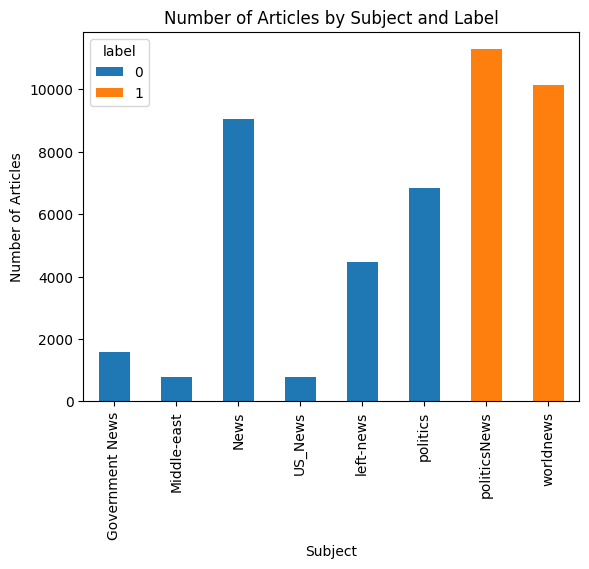

label                 0        1
subject                         
Government News  1570.0      NaN
Middle-east       778.0      NaN
News             9050.0      NaN
US_News           783.0      NaN
left-news        4459.0      NaN
politics         6841.0      NaN
politicsNews        NaN  11272.0
worldnews           NaN  10145.0


In [ ]:
subject_counts = df.groupby(['subject', 'label']).size().unstack()
subject_counts.plot(kind='bar', stacked=True)
plt.title('Number of Articles by Subject and Label')
plt.xlabel('Subject')
plt.ylabel('Number of Articles')
plt.show()
print(subject_counts)

In [ ]:
# Create a temporary date column for conversion
df['date'] = pd.to_datetime(df['date'], errors='coerce')
failed_rows = df[df['date'].isna()]
print(failed_rows.shape)
failed_rows # 有10筆date的資料是NULL，可以丟掉這些資料

(10, 5)


,title,text,subject,date,label
30775,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,NaT,0
36924,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,NaT,0
36925,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,NaT,0
37256,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,0
37257,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,0
38849,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,0
38850,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,0
40350,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,NaT,0
43286,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,0
43287,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,0


### 分析真假新聞在時間上的分佈
2017/9 - 2018/1 的 true data 特別多

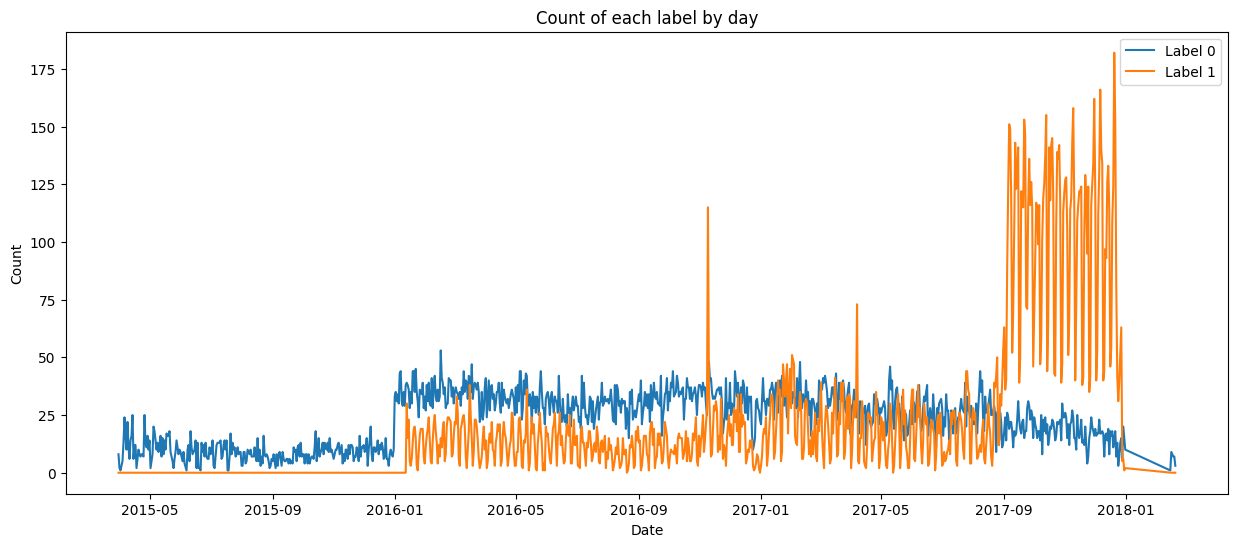

In [ ]:
df_resampled = df.groupby([pd.Grouper(key='date', freq='D'), 'label']).size().reset_index(name='count')
df_pivot = df_resampled.pivot(index='date', columns='label', values='count').fillna(0)
plt.figure(figsize=(15, 6))
for label in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[label], label=f'Label {label}')

plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.title('Count of each label by day')
plt.show()

### 真假新聞的data distribution

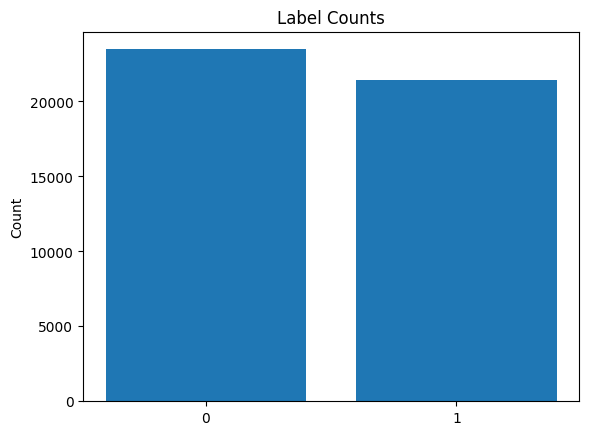

In [ ]:
label_counts = df['label'].value_counts()

plt.bar(label_counts.index, label_counts.values)

plt.title('Label Counts')
plt.xticks(label_counts.index, ['0', '1'])
plt.ylabel('Count')

plt.show()

### 分析 真news / 假news 哪些字特別多

In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from wordcloud import WordCloud , STOPWORDS
def word_cloud(target):
    wordcloud = WordCloud(stopwords=STOPWORDS , background_color='white' , width=2000 , height=1000 ).generate(" ".join(df[df['label']== target]['text']))
    plt.figure(1 , figsize=(15 ,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

true news 的 word cloud

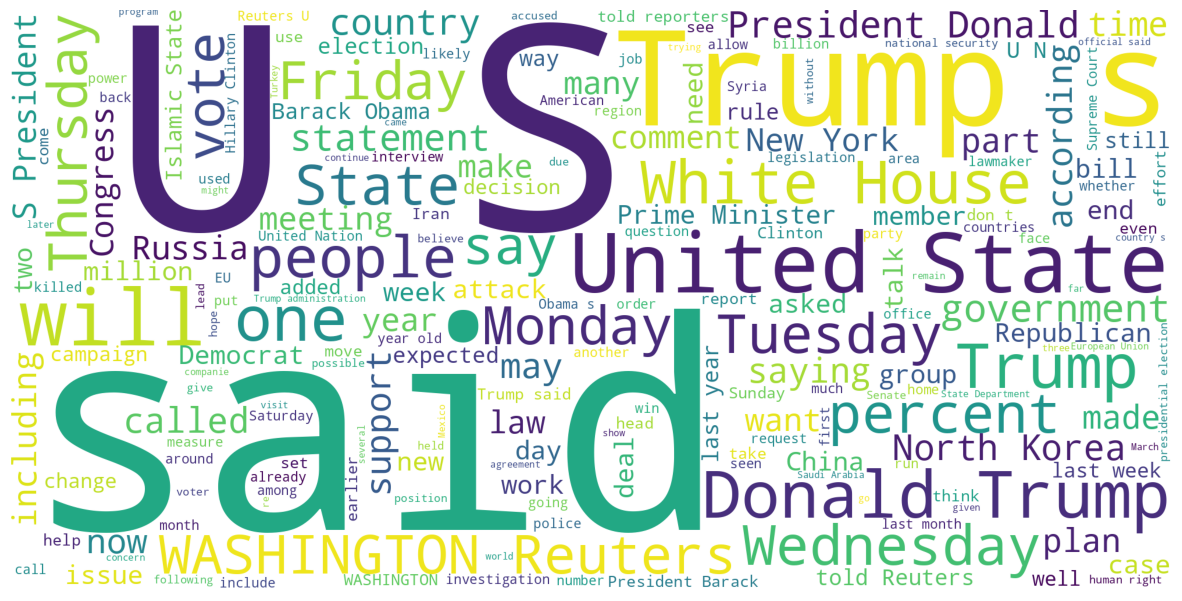

In [ ]:
word_cloud(1)

false news 的 word cloud

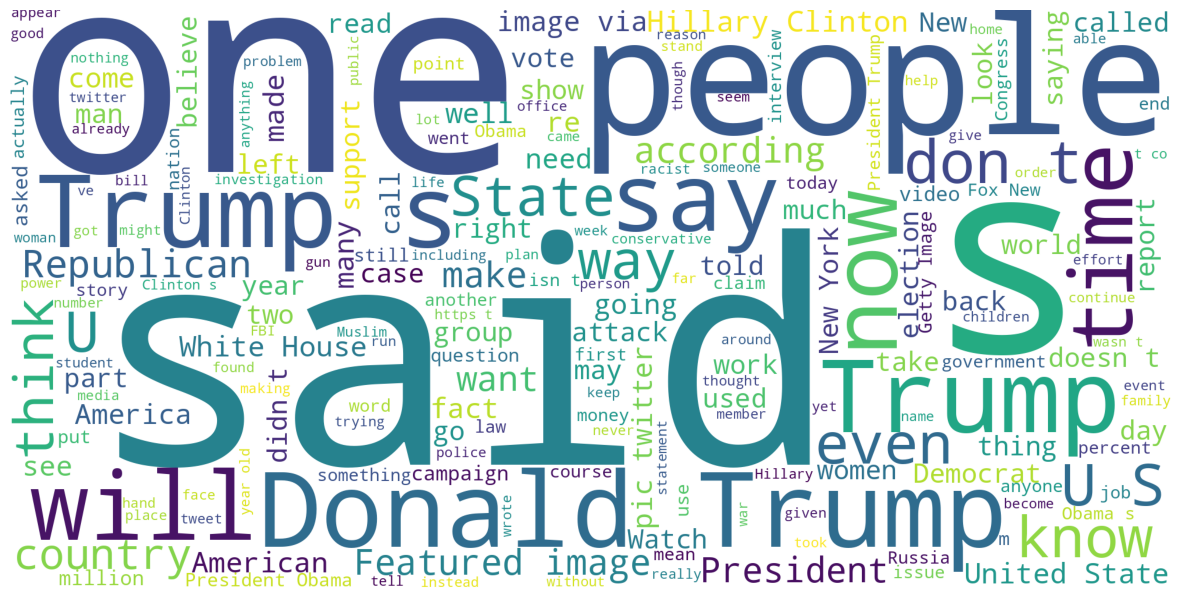

In [ ]:
word_cloud(0)

把真假新聞前20多的字print出來，比用word_cloud 看的還清楚

In [ ]:
from collections import defaultdict
import seaborn as sns
def generate_ngrams(text , n_grams=1):
    tokens = [token for token in text.lower().split(' ') if token !='' if token not in STOPWORDS ]
    ngrames = zip(*[tokens[i:] for i in range(n_grams) ])
    return [' '.join(ngram) for ngram in ngrames ]


def gen_ngram( n_gram=1 , count=50 ):
    N  = count
    true_news_unigram = defaultdict(int)
    fake_news_unigram = defaultdict(int)
    fake_news_bingram = defaultdict(int)
    true_news_bingram = defaultdict(int)

    for doc in df['text'][df['label'] == 1 ]:
        for word in generate_ngrams(doc , n_grams=n_gram):
            true_news_unigram[word] += 1

    for doc in df['text'][df['label'] == 0 ]:
        for word in generate_ngrams(doc , n_grams=n_gram):
            fake_news_unigram[word] += 1


    true_news_unigram = pd.DataFrame(sorted(true_news_unigram.items(), key=lambda x: x[1])[::-1])
    fake_news_unigram = pd.DataFrame( sorted(fake_news_unigram.items()  , key=lambda x : x[1] )[::-1])
    fig , axes = plt.subplots(ncols = 2 , figsize=(20 , 50) , dpi=60)
    plt.tight_layout()

    sns.barplot(y=true_news_unigram[0].values[:N] , x=true_news_unigram[1].values[:N] , ax=axes[0] , color='red'  )
    sns.barplot(y=fake_news_unigram[0].values[:N] , x=fake_news_unigram[1].values[:N] , ax=axes[1] , color='blue'  )


    for i in range(2):
        axes[i].spines['right'].set_visible(False)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', labelsize=13)
        axes[i].tick_params(axis='y', labelsize=13)

    axes[0].set_title(f'Top {N} most common unigrams in True  News', fontsize=15)
    axes[1].set_title(f'Top {N} most common unigrams in Fake  News', fontsize=15)

    plt.show()

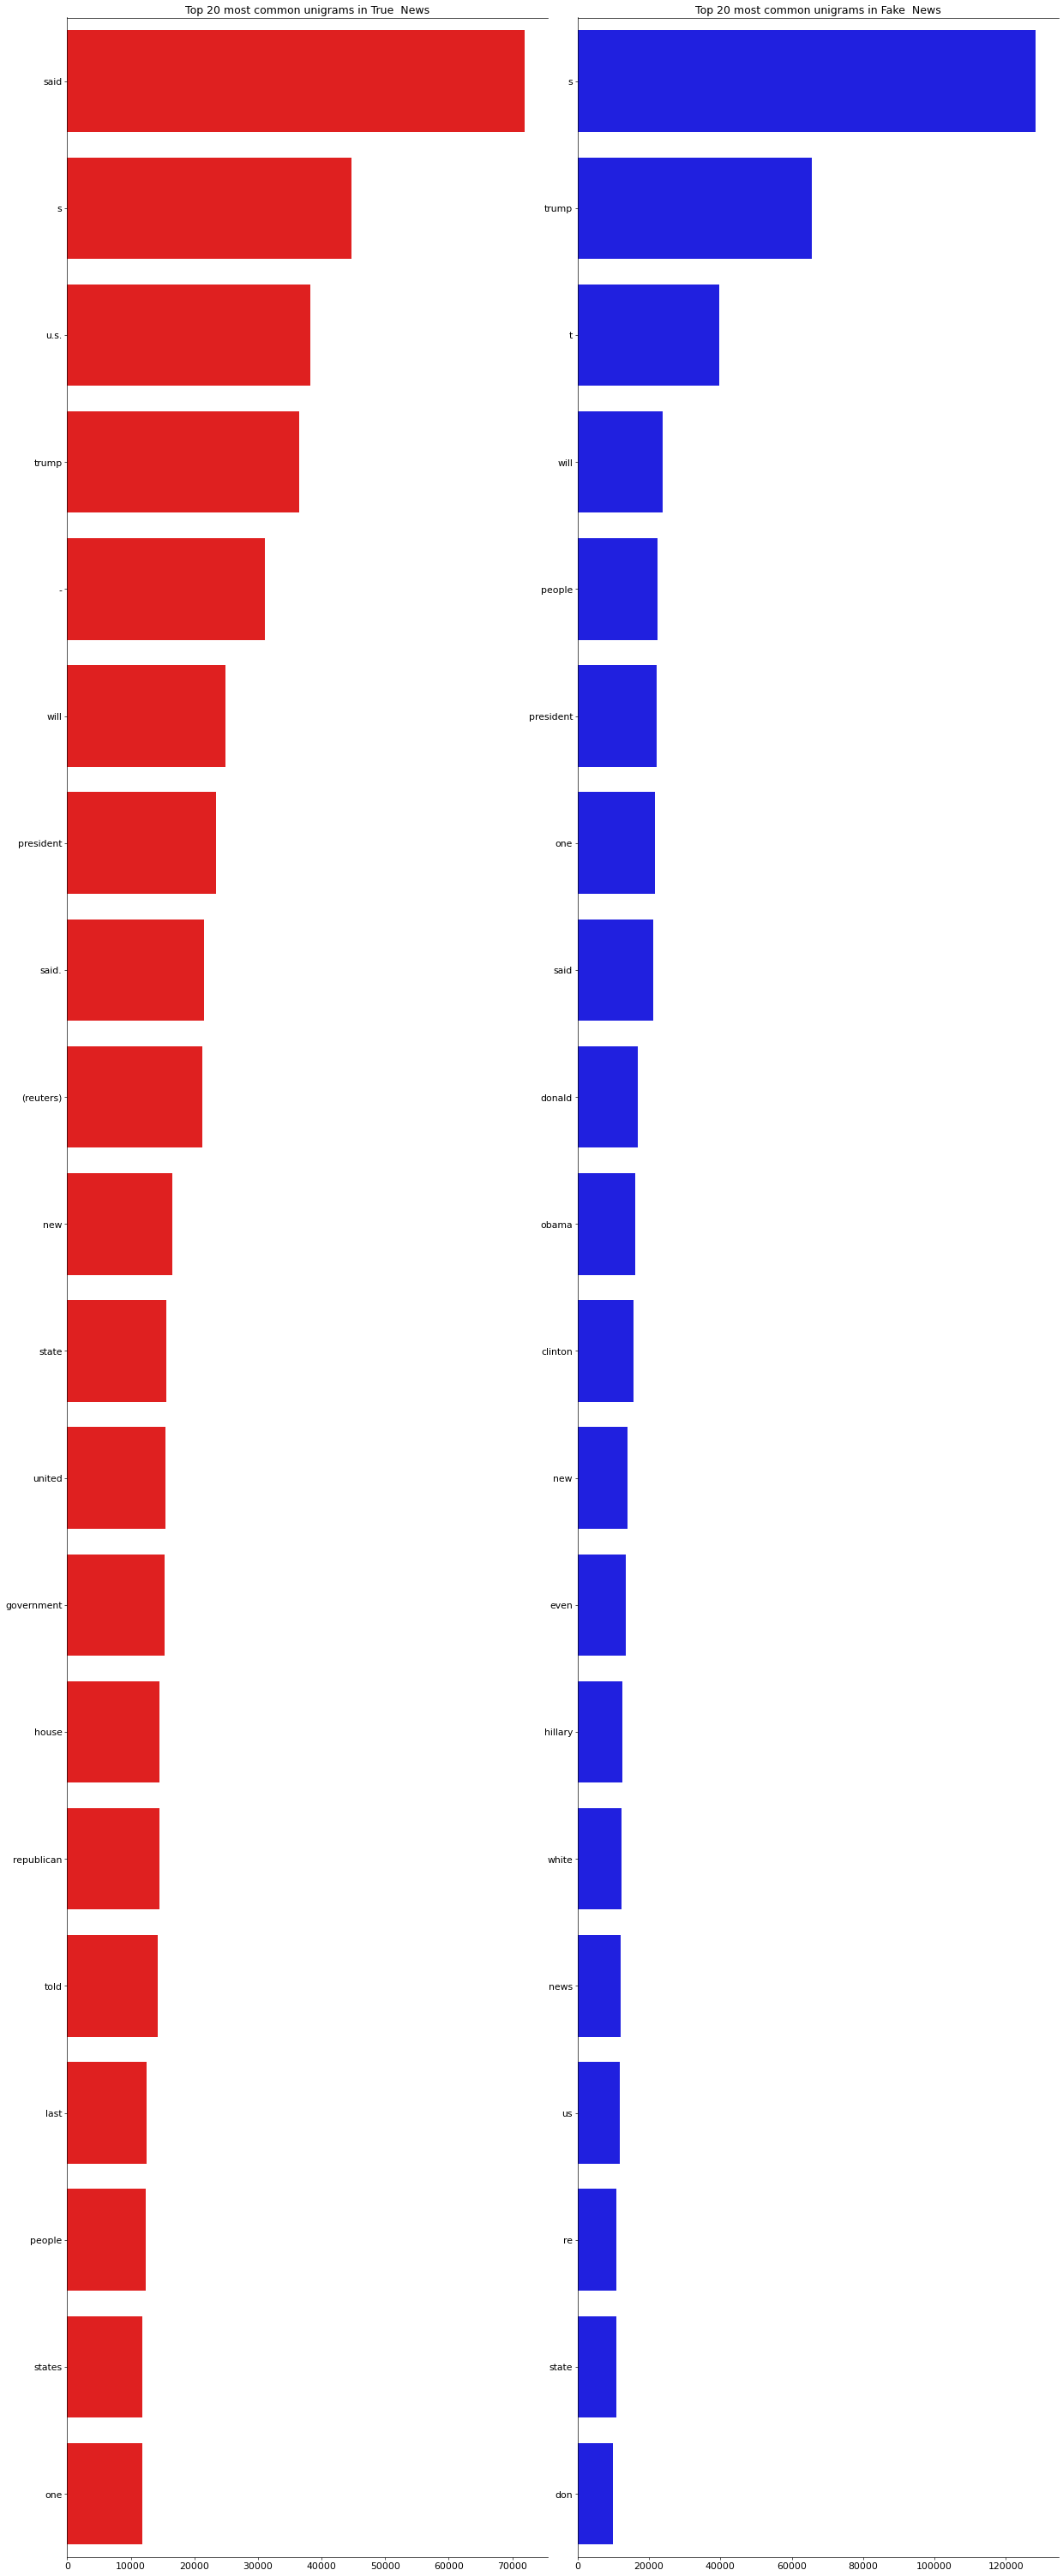

In [ ]:
gen_ngram(n_gram=1 ,count=20)

## Data preprocessing

### 處理date欄位
拆分data資料為3個columns:年、月、日

In [ ]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df

,title,text,subject,date,label,year,month,day
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,2017.0,12.0,31.0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,2017.0,12.0,29.0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,2017.0,12.0,31.0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,2017.0,12.0,30.0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,2017.0,12.0,29.0
...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16,0,2016.0,1.0,16.0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16,0,2016.0,1.0,16.0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15,0,2016.0,1.0,15.0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14,0,2016.0,1.0,14.0


In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### 去除stop word
先Clean title

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
  # 把不是「字母（a-z、A-Z）、數字（0-9）和空白格」拿掉
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  result = []
  tokens = nltk.word_tokenize(text.lower())
  for token in tokens:
    if token not in stop_words:
      result.append(token)
  return result

In [ ]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title_join'] = df['clean_title'].apply(lambda x: " ".join(x))
df

,title,text,subject,date,label,year,month,day,clean_title,clean_title_join
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,2017.0,12.0,31.0,"[us, budget, fight, looms, republicans, flip, ...",us budget fight looms republicans flip fiscal ...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,2017.0,12.0,29.0,"[us, military, accept, transgender, recruits, ...",us military accept transgender recruits monday...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,2017.0,12.0,31.0,"[senior, us, republican, senator, let, mr, mue...",senior us republican senator let mr mueller job
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,2017.0,12.0,30.0,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,2017.0,12.0,29.0,"[trump, wants, postal, service, charge, much, ...",trump wants postal service charge much amazon ...
...,...,...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16,0,2016.0,1.0,16.0,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated us sai...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16,0,2016.0,1.0,16.0,"[justice, yahoo, settles, email, privacy, clas...",justice yahoo settles email privacy classactio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15,0,2016.0,1.0,15.0,"[sunnistan, us, allied, safe, zone, plan, take...",sunnistan us allied safe zone plan take territ...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14,0,2016.0,1.0,14.0,"[blow, 700, million, al, jazeera, america, fin...",blow 700 million al jazeera america finally ca...


Clean texts

In [ ]:
df['clean_text'] = df['text'].apply(preprocess)
df['clean_text_join'] = df['clean_text'].apply(lambda x: " ".join(x))
df

,title,text,subject,date,label,year,month,day,clean_title,clean_title_join,clean_text,clean_text_join
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,2017.0,12.0,31.0,"[us, budget, fight, looms, republicans, flip, ...",us budget fight looms republicans flip fiscal ...,"[washington, reuters, head, conservative, repu...",washington reuters head conservative republica...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,2017.0,12.0,29.0,"[us, military, accept, transgender, recruits, ...",us military accept transgender recruits monday...,"[washington, reuters, transgender, people, all...",washington reuters transgender people allowed ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,2017.0,12.0,31.0,"[senior, us, republican, senator, let, mr, mue...",senior us republican senator let mr mueller job,"[washington, reuters, special, counsel, invest...",washington reuters special counsel investigati...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,2017.0,12.0,30.0,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...,"[washington, reuters, trump, campaign, adviser...",washington reuters trump campaign adviser geor...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,2017.0,12.0,29.0,"[trump, wants, postal, service, charge, much, ...",trump wants postal service charge much amazon ...,"[seattlewashington, reuters, president, donald...",seattlewashington reuters president donald tru...
...,...,...,...,...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16,0,2016.0,1.0,16.0,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated us sai...,"[21st, century, wire, says, 21wire, reported, ...",21st century wire says 21wire reported earlier...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16,0,2016.0,1.0,16.0,"[justice, yahoo, settles, email, privacy, clas...",justice yahoo settles email privacy classactio...,"[21st, century, wire, says, familiar, theme, w...",21st century wire says familiar theme whenever...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15,0,2016.0,1.0,15.0,"[sunnistan, us, allied, safe, zone, plan, take...",sunnistan us allied safe zone plan take territ...,"[patrick, henningsen, 21st, century, wireremem...",patrick henningsen 21st century wireremember o...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14,0,2016.0,1.0,14.0,"[blow, 700, million, al, jazeera, america, fin...",blow 700 million al jazeera america finally ca...,"[21st, century, wire, says, al, jazeera, ameri...",21st century wire says al jazeera america go h...


### 合併title and text
for training word emdding

In [ ]:
df['title_and_text'] = df['clean_text'] + df['clean_title']
df['title_and_text_join'] = df['title_and_text'].apply(lambda x: " ".join(x))
df

,title,text,date,label,year,month,day,clean_title,clean_title_join,clean_text,...,title_and_text_GloVe,Government News,Middle-east,News,US_News,left-news,politics,politicsNews,worldnews,title_and_text_join
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,2017-12-31,1,2017.0,12.0,31.0,"[us, budget, fight, looms, republicans, flip, ...",us budget fight looms republicans flip fiscal ...,"[washington, reuters, head, conservative, repu...",...,"[-0.07103713, 0.19391994, 0.26406604, -0.23755...",0,0,0,0,0,0,1,0,washington reuters head conservative republica...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,2017-12-29,1,2017.0,12.0,29.0,"[us, military, accept, transgender, recruits, ...",us military accept transgender recruits monday...,"[washington, reuters, transgender, people, all...",...,"[0.067112476, -0.032370564, 0.12386004, -0.068...",0,0,0,0,0,0,1,0,washington reuters transgender people allowed ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,2017-12-31,1,2017.0,12.0,31.0,"[senior, us, republican, senator, let, mr, mue...",senior us republican senator let mr mueller job,"[washington, reuters, special, counsel, invest...",...,"[-0.094400465, -0.03519834, 0.28105226, -0.236...",0,0,0,0,0,0,1,0,washington reuters special counsel investigati...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,2017-12-30,1,2017.0,12.0,30.0,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...,"[washington, reuters, trump, campaign, adviser...",...,"[-0.08509973, -0.13970101, 0.2515141, -0.11875...",0,0,0,0,0,0,1,0,washington reuters trump campaign adviser geor...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,2017-12-29,1,2017.0,12.0,29.0,"[trump, wants, postal, service, charge, much, ...",trump wants postal service charge much amazon ...,"[seattlewashington, reuters, president, donald...",...,"[-0.014203048, 0.10178995, 0.2180401, -0.14351...",0,0,0,0,0,0,1,0,seattlewashington reuters president donald tru...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,2016-01-16,0,2016.0,1.0,16.0,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated us sai...,"[21st, century, wire, says, 21wire, reported, ...",...,"[-0.03474338, 0.12717932, 0.31850666, -0.09156...",0,1,0,0,0,0,0,0,21st century wire says 21wire reported earlier...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,2016-01-16,0,2016.0,1.0,16.0,"[justice, yahoo, settles, email, privacy, clas...",justice yahoo settles email privacy classactio...,"[21st, century, wire, says, familiar, theme, w...",...,"[0.03321295, 0.032742966, 0.1218821, -0.078830...",0,1,0,0,0,0,0,0,21st century wire says familiar theme whenever...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,2016-01-15,0,2016.0,1.0,15.0,"[sunnistan, us, allied, safe, zone, plan, take...",sunnistan us allied safe zone plan take territ...,"[patrick, henningsen, 21st, century, wireremem...",...,"[-0.095426634, 0.1334976, 0.22138116, -0.03850...",0,1,0,0,0,0,0,0,patrick henningsen 21st century wireremember o...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,2016-01-14,0,2016.0,1.0,14.0,"[blow, 700, million, al, jazeera, america, fin...",blow 700 million al jazeera america finally ca...,"[21st, century, wire, says, al, jazeera, ameri...",...,"[0.0018369514, 0.14506035, 0.18093184, -0.2030...",0,1,0,0,0,0,0,0,21st century wire says al jazeera america go h...


### 新增 num_elements 欄位
計算每則新聞的token數

In [ ]:
# Count the number of elements in each row
df['num_elements'] = df['title_and_text'].apply(len)
max_length = df['num_elements'].idxmax()
print(f'The max length of the news = {max_length}')
df.head()

The max length of the news = 43720


,title,text,subject,date,label,year,month,day,clean_title,clean_title_join,clean_text,clean_text_join,title_and_text,num_elements
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,2017.0,12.0,31.0,"[us, budget, fight, looms, republicans, flip, ...",us budget fight looms republicans flip fiscal ...,"[washington, reuters, head, conservative, repu...",washington reuters head conservative republica...,"[washington, reuters, head, conservative, repu...",462
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,2017.0,12.0,29.0,"[us, military, accept, transgender, recruits, ...",us military accept transgender recruits monday...,"[washington, reuters, transgender, people, all...",washington reuters transgender people allowed ...,"[washington, reuters, transgender, people, all...",389
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,2017.0,12.0,31.0,"[senior, us, republican, senator, let, mr, mue...",senior us republican senator let mr mueller job,"[washington, reuters, special, counsel, invest...",washington reuters special counsel investigati...,"[washington, reuters, special, counsel, invest...",272
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,2017.0,12.0,30.0,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...,"[washington, reuters, trump, campaign, adviser...",washington reuters trump campaign adviser geor...,"[washington, reuters, trump, campaign, adviser...",238
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,2017.0,12.0,29.0,"[trump, wants, postal, service, charge, much, ...",trump wants postal service charge much amazon ...,"[seattlewashington, reuters, president, donald...",seattlewashington reuters president donald tru...,"[seattlewashington, reuters, president, donald...",518


## Embedding

### word2vec

In [ ]:
from gensim.models import Word2Vec
import nltk

In [ ]:
nltk.download('punkt')
start = time.time()
model_W2V = Word2Vec(df['title_and_text'], min_count=1, vector_size=100)
end = time.time()
W2V_training_time = round(end-start,2)
print('This process took {} seconds'.format(W2V_training_time))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


This process took 106.77 seconds


In [ ]:
def embed_text_using_word2vec(tokenized_text):
  embeddings = [model_W2V.wv[word] for word in tokenized_text]
  return np.mean(embeddings, axis=0)

In [ ]:
df['title_and_text_W2V'] = df['title_and_text'].apply(embed_text_using_word2vec)
df.head()

,title,text,subject,date,label,year,month,day,clean_title,clean_title_join,clean_text,clean_text_join,title_and_text,num_elements,title_and_text_W2V
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,2017.0,12.0,31.0,"[us, budget, fight, looms, republicans, flip, ...",us budget fight looms republicans flip fiscal ...,"[washington, reuters, head, conservative, repu...",washington reuters head conservative republica...,"[washington, reuters, head, conservative, repu...",462,"[-0.008303707, 0.1772398, 0.22774242, -0.59688..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,2017.0,12.0,29.0,"[us, military, accept, transgender, recruits, ...",us military accept transgender recruits monday...,"[washington, reuters, transgender, people, all...",washington reuters transgender people allowed ...,"[washington, reuters, transgender, people, all...",389,"[0.305831, -0.01625813, 0.16208468, -0.3167030..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,2017.0,12.0,31.0,"[senior, us, republican, senator, let, mr, mue...",senior us republican senator let mr mueller job,"[washington, reuters, special, counsel, invest...",washington reuters special counsel investigati...,"[washington, reuters, special, counsel, invest...",272,"[-0.022980217, -0.1864772, 0.47713584, -0.5065..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,2017.0,12.0,30.0,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...,"[washington, reuters, trump, campaign, adviser...",washington reuters trump campaign adviser geor...,"[washington, reuters, trump, campaign, adviser...",238,"[0.12547866, -0.32482514, 0.5927679, -0.495028..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,2017.0,12.0,29.0,"[trump, wants, postal, service, charge, much, ...",trump wants postal service charge much amazon ...,"[seattlewashington, reuters, president, donald...",seattlewashington reuters president donald tru...,"[seattlewashington, reuters, president, donald...",518,"[0.05274501, 0.088252194, 0.22815453, -0.48144..."


### GloVe

In [ ]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import nltk

In [ ]:
glove_input_file = '/content/drive/MyDrive/Colab Notebooks/資料安全的資訊科學/GloVe/glove.6B.100d.txt'
word2vec_output_file = '/content/drive/MyDrive/Colab Notebooks/資料安全的資訊科學/GloVe/glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

<ipython-input-51-9cdd5cfd2e48>:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400000, 100)

In [ ]:
model_GloVe = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
def get_vector(word):
  if word in model_GloVe:
    return model_GloVe[word]
  else:
    return None

def get_embedding(tokens):
  vectors = [get_vector(word) for word in tokens]
  vectors = [vector for vector in vectors if vector is not None]
  
  if len(vectors) == 0:
    return None
  else:
    return sum(vectors) / len(vectors)

In [ ]:
start = time.time()
df['title_and_text_GloVe'] = df['title_and_text'].apply(get_embedding)
end = time.time()
GloVe_training_time = round(end-start,2)
print('This process took {} seconds'.format(GloVe_training_time))

This process took 26.65 seconds


In [ ]:
df.head()

,title,text,subject,date,label,year,month,day,clean_title,clean_title_join,clean_text,clean_text_join,title_and_text,num_elements,title_and_text_W2V,title_and_text_GloVe
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,2017.0,12.0,31.0,"[us, budget, fight, looms, republicans, flip, ...",us budget fight looms republicans flip fiscal ...,"[washington, reuters, head, conservative, repu...",washington reuters head conservative republica...,"[washington, reuters, head, conservative, repu...",462,"[-0.008303707, 0.1772398, 0.22774242, -0.59688...","[-0.07103713, 0.19391994, 0.26406604, -0.23755..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,2017.0,12.0,29.0,"[us, military, accept, transgender, recruits, ...",us military accept transgender recruits monday...,"[washington, reuters, transgender, people, all...",washington reuters transgender people allowed ...,"[washington, reuters, transgender, people, all...",389,"[0.305831, -0.01625813, 0.16208468, -0.3167030...","[0.067112476, -0.032370564, 0.12386004, -0.068..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,2017.0,12.0,31.0,"[senior, us, republican, senator, let, mr, mue...",senior us republican senator let mr mueller job,"[washington, reuters, special, counsel, invest...",washington reuters special counsel investigati...,"[washington, reuters, special, counsel, invest...",272,"[-0.022980217, -0.1864772, 0.47713584, -0.5065...","[-0.094400465, -0.03519834, 0.28105226, -0.236..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,2017.0,12.0,30.0,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...,"[washington, reuters, trump, campaign, adviser...",washington reuters trump campaign adviser geor...,"[washington, reuters, trump, campaign, adviser...",238,"[0.12547866, -0.32482514, 0.5927679, -0.495028...","[-0.08509973, -0.13970101, 0.2515141, -0.11875..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,2017.0,12.0,29.0,"[trump, wants, postal, service, charge, much, ...",trump wants postal service charge much amazon ...,"[seattlewashington, reuters, president, donald...",seattlewashington reuters president donald tru...,"[seattlewashington, reuters, president, donald...",518,"[0.05274501, 0.088252194, 0.22815453, -0.48144...","[-0.014203048, 0.10178995, 0.2180401, -0.14351..."


## Feature Engineers

### 處理subjects欄位
one-hot encoding subject 欄位

In [ ]:
one_hot_subject = pd.get_dummies(df['subject'])
df = df.drop('subject',axis = 1)
df = df.join(one_hot_subject)
df.head()

,title,text,date,label,year,month,day,clean_title,clean_title_join,clean_text,...,title_and_text_W2V,title_and_text_GloVe,Government News,Middle-east,News,US_News,left-news,politics,politicsNews,worldnews
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,2017-12-31,1,2017.0,12.0,31.0,"[us, budget, fight, looms, republicans, flip, ...",us budget fight looms republicans flip fiscal ...,"[washington, reuters, head, conservative, repu...",...,"[-0.008303707, 0.1772398, 0.22774242, -0.59688...","[-0.07103713, 0.19391994, 0.26406604, -0.23755...",0,0,0,0,0,0,1,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,2017-12-29,1,2017.0,12.0,29.0,"[us, military, accept, transgender, recruits, ...",us military accept transgender recruits monday...,"[washington, reuters, transgender, people, all...",...,"[0.305831, -0.01625813, 0.16208468, -0.3167030...","[0.067112476, -0.032370564, 0.12386004, -0.068...",0,0,0,0,0,0,1,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,2017-12-31,1,2017.0,12.0,31.0,"[senior, us, republican, senator, let, mr, mue...",senior us republican senator let mr mueller job,"[washington, reuters, special, counsel, invest...",...,"[-0.022980217, -0.1864772, 0.47713584, -0.5065...","[-0.094400465, -0.03519834, 0.28105226, -0.236...",0,0,0,0,0,0,1,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,2017-12-30,1,2017.0,12.0,30.0,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...,"[washington, reuters, trump, campaign, adviser...",...,"[0.12547866, -0.32482514, 0.5927679, -0.495028...","[-0.08509973, -0.13970101, 0.2515141, -0.11875...",0,0,0,0,0,0,1,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,2017-12-29,1,2017.0,12.0,29.0,"[trump, wants, postal, service, charge, much, ...",trump wants postal service charge much amazon ...,"[seattlewashington, reuters, president, donald...",...,"[0.05274501, 0.088252194, 0.22815453, -0.48144...","[-0.014203048, 0.10178995, 0.2180401, -0.14351...",0,0,0,0,0,0,1,0


### 儲存table

In [ ]:
df.to_pickle('/content/drive/MyDrive/Colab Notebooks/資料安全的資訊科學/preprocess.pkl')

## Train classifier

### 切割資料

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/資料安全的資訊科學/preprocess.pkl')

In [ ]:
df=df.dropna()

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('label',axis=1)
y = df['label']

# Splitting the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### fasttext classifier

In [ ]:
X_train_for_fasttext = X_train['title_and_text_join']
X_train_for_fasttext.iloc[0]

'ready take america back video col allen west explodes iran deal fiery emotional times square speech'

In [ ]:
X_test_for_fasttext = X_test['title_and_text_join']
X_test_for_fasttext.iloc[0]

'baghdad reuters two attackers shot several civilians monday nahrawan area southeast baghdad one blew killed security forces iraqi interior ministry said without providing official casualty figures local media reported least 17 people killed 28 wounded islamic state claimed responsibility attack described interior ministry spokesman terrorist attack two terrorist suicide attackers fired indiscriminately citizens nahrawan area sunni muslim militant group amaq news agency said killed 35 members one iranbacked shi ite militias known popular mobilisation forces iraqi security officials say islamic state likely wage insurgency selfproclaimed caliphate collapsed militants dislodged territories held across swathe iraq syria suicide attack targets area southeast baghdad'

In [ ]:
type(y_train.iloc[0])

numpy.int64

In [ ]:
with open('/content/train_for_fasttext.txt', 'w', encoding='utf-8') as file:
  for i in range(len(X_train_for_fasttext)):
    file.write('__label__' + str(y_train.iloc[i]) + ' ' + X_train_for_fasttext.iloc[i] + '\n')

with open('/content/test_for_fasttext.txt', 'w', encoding='utf-8') as file:
  for i in range(len(X_test_for_fasttext)):
    file.write('__label__' + str(y_test.iloc[i]) + ' ' + X_test_for_fasttext.iloc[i] + '\n')

In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393432 sha256=3ae5477c907922f1407e8abd9f4a0932d0c6a2bbbbc62da023194dd09d755131
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import fasttext
start = time.time()
model_fasttext = fasttext.train_supervised(input='/content/train_for_fasttext.txt', epoch=50)
end = time.time()
fasttext_training_time = round(end-start,2)
print('This process took {} seconds'.format(fasttext_training_time))

# Save the model
model_fasttext.save_model('/content/drive/MyDrive/Colab Notebooks/資料安全的資訊科學/fasttext/text_classification_model.bin')

This process took 167.66 seconds


In [ ]:
# Test the model
fasttext_accuracy = model_fasttext.test('/content/test_for_fasttext.txt')
print('Test Accuracy:', fasttext_accuracy[1])

Test Accuracy: 0.9967698819336155


In [ ]:
# Make predictions on new data
text = 'Trump is thin and handsome.'
labels, prob = model_fasttext.predict(text)
print('Label:', labels[0])
print('Probability:', prob[0])

Label: __label__0
Probability: 1.0000100135803223


In [ ]:
predictions = []
for i in X_test_for_fasttext:
  labels, prob = model_fasttext.predict(i)
  predictions.append(labels[0][-1])
print(type(predictions[0]))

<class 'str'>


In [ ]:
predictions = [int(element) for element in predictions]

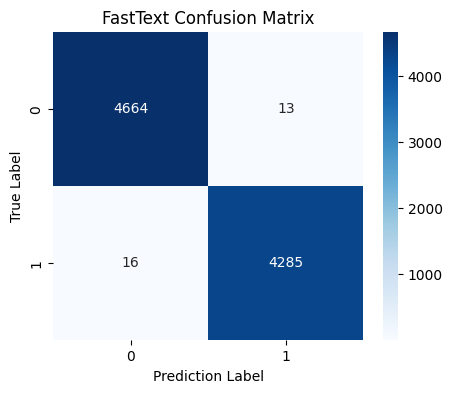

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

# Get labels
labels = np.unique(y_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.title('FastText Confusion Matrix')
plt.show()

### SVM classifier (Data without Text)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32319 entries, 36851 to 32815
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 32319 non-null  object        
 1   text                  32319 non-null  object        
 2   date                  32319 non-null  datetime64[ns]
 3   year                  32319 non-null  float64       
 4   month                 32319 non-null  float64       
 5   day                   32319 non-null  float64       
 6   clean_title           32319 non-null  object        
 7   clean_title_join      32319 non-null  object        
 8   clean_text            32319 non-null  object        
 9   clean_text_join       32319 non-null  object        
 10  title_and_text        32319 non-null  object        
 11  num_elements          32319 non-null  int64         
 12  title_and_text_W2V    32319 non-null  object        
 13  title_and_te

In [ ]:
X_train_for_SVM_noText =X_train[["year","month","day","num_elements","Government News","Middle-east","News","US_News","left-news","politics","politicsNews","worldnews"]]
X_test_for_SVM_noText =X_test[["year","month","day","num_elements","Government News","Middle-east","News","US_News","left-news","politics","politicsNews","worldnews"]]

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
model_SVM = svm.SVC()
start = time.time()
model_SVM.fit(X_train_for_SVM_noText, y_train)
y_test_pred = model_SVM.predict(X_test_for_SVM_noText)
end = time.time()
SVM_noText_training_time = round(end-start,2)
print('This process took {} seconds'.format(SVM_noText_training_time))
# Accurcy
SVM_noText_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", SVM_noText_accuracy)

This process took 110.08 seconds
Accuracy: 0.5209400757406994


In [ ]:
X_train_for_SVM_noText.shape

(32319, 12)

In [ ]:
X_test_for_SVM_noText.shape

(8978, 12)

### SVM classifier (Data uses Text) - word2vec

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32319 entries, 36851 to 32815
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 32319 non-null  object        
 1   text                  32319 non-null  object        
 2   date                  32319 non-null  datetime64[ns]
 3   year                  32319 non-null  float64       
 4   month                 32319 non-null  float64       
 5   day                   32319 non-null  float64       
 6   clean_title           32319 non-null  object        
 7   clean_title_join      32319 non-null  object        
 8   clean_text            32319 non-null  object        
 9   clean_text_join       32319 non-null  object        
 10  title_and_text        32319 non-null  object        
 11  num_elements          32319 non-null  int64         
 12  title_and_text_W2V    32319 non-null  object        
 13  title_and_te

In [ ]:
X_train_for_SVM_Text_W2V = X_train['title_and_text_W2V']
X_test_for_SVM_Text_W2V = X_test['title_and_text_W2V']

In [ ]:
X_train_for_SVM_Text_W2V.shape

(32319,)

In [ ]:
def flatten_sentence(sentence):
  feature = np.zeros(100)
  for i in range(len(sentence)):
    feature[i] = sentence[i]
  return feature

In [ ]:
X_train_for_SVM_Text_W2V = [flatten_sentence(i) for i in X_train_for_SVM_Text_W2V]
X_test_for_SVM_Text_W2V = [flatten_sentence(i) for i in X_test_for_SVM_Text_W2V]

In [ ]:
X_train_for_SVM_Text_W2V[:2]

[array([ 0.19606261,  0.93580377,  0.5623076 , -0.08896078,  0.00364852,
         0.86487162, -0.13984145,  0.09233971,  0.20102102, -0.36479431,
         0.20039931,  0.30521902, -0.86917377,  0.07278875, -0.80981386,
        -0.06392077,  0.87935317, -0.59182751,  0.36881304, -0.1864796 ,
         0.41396484, -0.24262276, -0.19633394,  0.63218409,  0.05643523,
         0.62888598, -0.46870869, -0.53638136, -0.16655381, -1.00039005,
        -0.19268727, -0.13475032,  0.06554288, -0.45153475, -0.40921223,
        -0.76303613,  0.15589751,  0.3101424 ,  0.10203452,  0.54293817,
         1.50703275, -0.04753727, -0.50674641,  0.12450333,  0.29021147,
        -0.63644624, -0.32422182,  0.14581439,  0.62438762,  0.44843131,
        -0.22582342, -1.42843699,  0.05524411, -0.11359742, -0.80971223,
         0.32156777,  0.7828393 , -0.11833142,  0.05331302, -0.34619978,
         0.64281142,  0.29867658,  0.4597373 ,  0.06983428, -0.23357628,
         0.249321  ,  0.38594288, -0.20577356, -0.3

In [ ]:
model_SVM_W2V = svm.SVC()
start = time.time()
model_SVM_W2V.fit(X_train_for_SVM_Text_W2V, y_train)
end = time.time()
SVM_Text_W2V_training_time = round(end-start,2)
print('This process took {} seconds'.format(SVM_Text_W2V_training_time))

This process took 16.12 seconds


In [ ]:
# Accurcy
y_test_pred = model_SVM_W2V.predict(X_test_for_SVM_Text_W2V)
SVM_W2V_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", SVM_W2V_accuracy)

Accuracy: 0.9793940744040989


### SVM classifier (Data uses Text) - GloVe

In [ ]:
X_train_for_SVM_Text_GV = X_train['title_and_text_GloVe']
X_test_for_SVM_Text_GV = X_test['title_and_text_GloVe']

In [ ]:
X_train_for_SVM_Text_GV.shape

(32319,)

In [ ]:
X_train_for_SVM_Text_GV = [flatten_sentence(i) for i in X_train_for_SVM_Text_GV]
X_test_for_SVM_Text_GV = [flatten_sentence(i) for i in X_test_for_SVM_Text_GV]

In [ ]:
model_SVM_GV = svm.SVC()
start = time.time()
model_SVM_GV.fit(X_train_for_SVM_Text_GV, y_train)
end = time.time()
SVM_Text_GV_training_time = round(end-start,2)
print('This process took {} seconds'.format(SVM_Text_GV_training_time))

This process took 28.29 seconds


In [ ]:
# Accurcy
y_test_pred = model_SVM_GV.predict(X_test_for_SVM_Text_GV)
SVM_GV_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", SVM_GV_accuracy)

Accuracy: 0.9512140788594342


### SVM classifier (Data uses Text) - PCA first - word2vec

In [ ]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=50)
pca_model.fit(X_train_for_SVM_Text_W2V)
print("Sum of variance ratios: ",sum(pca_model.explained_variance_ratio_))

Sum of variance ratios:  0.9397982637846533


In [ ]:
X_train_for_SVM_Text_W2V_PCA = pca_model.transform(X_train_for_SVM_Text_W2V)
X_train_for_SVM_Text_W2V_PCA.shape

(32319, 50)

In [ ]:
X_test_for_SVM_Text_W2V_PCA = pca_model.transform(X_test_for_SVM_Text_W2V)
X_test_for_SVM_Text_W2V_PCA.shape

(8978, 50)

In [ ]:
model_SVM_W2V_PCA = svm.SVC()
start = time.time()
model_SVM_W2V_PCA.fit(X_train_for_SVM_Text_W2V_PCA, y_train)
end = time.time()
SVM_Text_W2V_PCA_training_time = round(end-start,2)
print('This process took {} seconds'.format(SVM_Text_W2V_PCA_training_time))

This process took 7.75 seconds


In [ ]:
# Accurcy
y_test_pred = model_SVM_W2V_PCA.predict(X_test_for_SVM_Text_W2V_PCA)
SVM_W2V_PCA_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", SVM_W2V_PCA_accuracy)

Accuracy: 0.9734907551793273


### SVM classifier (Data uses Text) - PCA first - GloVe

In [ ]:
pca_model_2 = PCA(n_components=50)
pca_model_2.fit(X_train_for_SVM_Text_GV)
print("Sum of variance ratios: ",sum(pca_model_2.explained_variance_ratio_))

Sum of variance ratios:  0.9210734020952286


In [ ]:
X_train_for_SVM_Text_GV_PCA = pca_model_2.transform(X_train_for_SVM_Text_GV)
X_train_for_SVM_Text_GV_PCA.shape

(32319, 50)

In [ ]:
X_test_for_SVM_Text_GV_PCA = pca_model_2.transform(X_test_for_SVM_Text_GV)
X_test_for_SVM_Text_GV_PCA.shape

(8978, 50)

In [ ]:
model_SVM_GV_PCA = svm.SVC()
start = time.time()
model_SVM_GV_PCA.fit(X_train_for_SVM_Text_GV_PCA, y_train)
end = time.time()
SVM_Text_GV_PCA_training_time = round(end-start,2)
print('This process took {} seconds'.format(SVM_Text_GV_PCA_training_time))

# Accurcy
y_test_pred = model_SVM_GV_PCA.predict(X_test_for_SVM_Text_GV_PCA)
SVM_GV_PCA_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", SVM_GV_PCA_accuracy)

This process took 12.46 seconds
Accuracy: 0.9599019826241925


##### Compare SVM

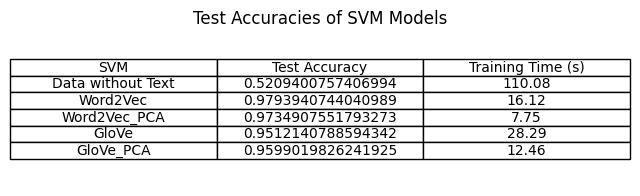

In [ ]:
# Assuming you have a list of test accuracies for each SVM model
test_accuracies = [SVM_noText_accuracy, SVM_W2V_accuracy, SVM_W2V_PCA_accuracy, SVM_GV_accuracy, SVM_GV_PCA_accuracy]
training_times = [SVM_noText_training_time, SVM_Text_W2V_training_time, SVM_Text_W2V_PCA_training_time, SVM_Text_GV_training_time, SVM_Text_GV_PCA_training_time] 
# Create a pandas DataFrame with the accuracies
data = {'SVM': ['Data without Text', 'Word2Vec', 'Word2Vec_PCA', 'GloVe', 'GloVe_PCA'],
        'Test Accuracy': test_accuracies,
        'Training Time (s)': training_times}
df = pd.DataFrame(data)

# Plot the table
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

plt.title('Test Accuracies of SVM Models')
plt.show()

### LSTM - Word2Vec

In [ ]:
X_train_for_w2v = X_train["title_and_text_W2V"]
X_val_for_w2v = X_val["title_and_text_W2V"]
X_test_for_w2v = X_test["title_and_text_W2V"]

In [ ]:
X_train_np = np.array(X_train_for_w2v.to_list())
X_train_np = np.reshape(X_train_np, (X_train_np.shape[0], 1, X_train_np.shape[1]))
X_val_np = np.array(X_val_for_w2v.to_list())
X_val_np = np.reshape(X_val_np, (X_val_np.shape[0], 1, X_val_np.shape[1]))
X_test_np = np.array(X_test_for_w2v.to_list())
X_test_np = np.reshape(X_test_np, (X_test_np.shape[0], 1, X_test_np.shape[1]))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
num_classes = len(np.unique(y_train))
model_LSTM_W2V = Sequential()
model_LSTM_W2V.add(LSTM(128, input_shape=(X_train_np.shape[1], X_train_np.shape[2])))
model_LSTM_W2V.add(Dense(num_classes, activation='softmax'))

model_LSTM_W2V.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# 訓練模型
start = time.time()
history = model_LSTM_W2V.fit(X_train_np, y_train, 
                    validation_data=(X_val_np, y_val),
                    epochs=20, batch_size=128, callbacks=[early_stopping])
end = time.time()
LSTM_W2V_training_time = round(end-start,2)
print('This process took {} seconds'.format(LSTM_W2V_training_time))

Epoch 1/20
253/253 [==============================] - 4s 6ms/step - loss: 0.1980 - accuracy: 0.9273 - val_loss: 0.1180 - val_accuracy: 0.9549
Epoch 2/20
253/253 [==============================] - 1s 4ms/step - loss: 0.1147 - accuracy: 0.9569 - val_loss: 0.1221 - val_accuracy: 0.9515
Epoch 3/20
253/253 [==============================] - 1s 5ms/step - loss: 0.0989 - accuracy: 0.9637 - val_loss: 0.0957 - val_accuracy: 0.9624
Epoch 4/20
253/253 [==============================] - 2s 6ms/step - loss: 0.0891 - accuracy: 0.9674 - val_loss: 0.0911 - val_accuracy: 0.9652
Epoch 5/20
253/253 [==============================] - 2s 9ms/step - loss: 0.0836 - accuracy: 0.9690 - val_loss: 0.0942 - val_accuracy: 0.9652
Epoch 6/20
253/253 [==============================] - 3s 12ms/step - loss: 0.0800 - accuracy: 0.9704 - val_loss: 0.0882 - val_accuracy: 0.9655
Epoch 7/20
253/253 [==============================] - 2s 9ms/step - loss: 0.0755 - accuracy: 0.9720 - val_loss: 0.0820 - val_accuracy: 0.9677
Epoch

In [ ]:
y_pred = model_LSTM_W2V.predict(X_test_np)
y_pred_labels = np.argmax(y_pred, axis=1)
LSTM_W2V_accuracy = np.mean(y_pred_labels == y_test)
print("accuracy:", LSTM_W2V_accuracy)

281/281 [==============================] - 1s 1ms/step
accuracy: 0.9807306749832925


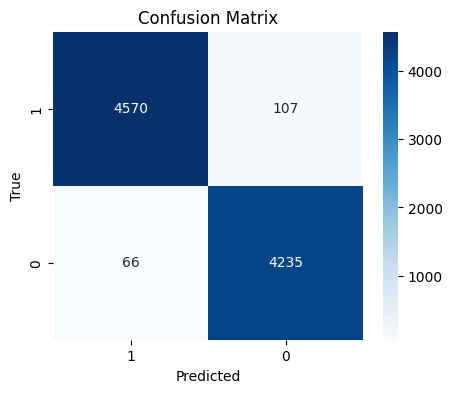

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=[1,0], yticklabels=[1,0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### LSTM - GloVe

In [ ]:
X_train_for_GV = X_train["title_and_text_GloVe"]
X_val_for_GV = X_val["title_and_text_GloVe"]
X_test_for_GV = X_test["title_and_text_GloVe"]

In [ ]:
X_train_np = np.array(X_train_for_GV.to_list())
X_train_np = np.reshape(X_train_np, (X_train_np.shape[0], 1, X_train_np.shape[1]))
X_val_np = np.array(X_val_for_GV.to_list())
X_val_np = np.reshape(X_val_np, (X_val_np.shape[0], 1, X_val_np.shape[1]))
X_test_np = np.array(X_test_for_GV.to_list())
X_test_np = np.reshape(X_test_np, (X_test_np.shape[0], 1, X_test_np.shape[1]))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
num_classes = len(np.unique(y_train))
model_LSTM_GV = Sequential()
model_LSTM_GV.add(LSTM(128, input_shape=(X_train_np.shape[1], X_train_np.shape[2])))
model_LSTM_GV.add(Dense(num_classes, activation='softmax'))

model_LSTM_GV.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

start = time.time()
history = model_LSTM_GV.fit(X_train_np, y_train, 
                    validation_data=(X_val_np, y_val),
                    epochs=50, batch_size=128,callbacks=[early_stopping])
end = time.time()
LSTM_GV_training_time = round(end-start,2)
print('This process took {} seconds'.format(LSTM_GV_training_time))

Epoch 1/50
253/253 [==============================] - 4s 6ms/step - loss: 0.2765 - accuracy: 0.9000 - val_loss: 0.1949 - val_accuracy: 0.9229
Epoch 2/50
253/253 [==============================] - 2s 6ms/step - loss: 0.1803 - accuracy: 0.9305 - val_loss: 0.1693 - val_accuracy: 0.9351
Epoch 3/50
253/253 [==============================] - 2s 6ms/step - loss: 0.1676 - accuracy: 0.9355 - val_loss: 0.1619 - val_accuracy: 0.9385
Epoch 4/50
253/253 [==============================] - 2s 7ms/step - loss: 0.1619 - accuracy: 0.9360 - val_loss: 0.1546 - val_accuracy: 0.9432
Epoch 5/50
253/253 [==============================] - 2s 9ms/step - loss: 0.1568 - accuracy: 0.9396 - val_loss: 0.1498 - val_accuracy: 0.9451
Epoch 6/50
253/253 [==============================] - 2s 9ms/step - loss: 0.1528 - accuracy: 0.9410 - val_loss: 0.1556 - val_accuracy: 0.9415
Epoch 7/50
253/253 [==============================] - 2s 8ms/step - loss: 0.1525 - accuracy: 0.9420 - val_loss: 0.1448 - val_accuracy: 0.9465
Epoch 

In [ ]:
y_pred = model_LSTM_GV.predict(X_test_np)
y_pred_labels = np.argmax(y_pred, axis=1)
LSTM_GV_accuracy = np.mean(y_pred_labels == y_test)
print("test accuracy:", LSTM_GV_accuracy)

281/281 [==============================] - 1s 1ms/step
test accuracy: 0.9580084651370016


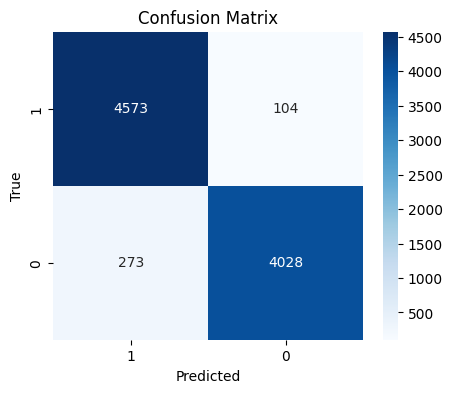

In [ ]:
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=[1,0], yticklabels=[1,0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### BERT

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
class NewsDataset(Dataset):
  def __init__(self, df, labels, tokenizer, max_len):
    self.df = df.reset_index(drop=True)  # reset index
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, item):
    text = str(self.df['clean_title_join'].iloc[item]) + ' ' + str(self.df['clean_text_join'].iloc[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

In [ ]:
max_len = 512  
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test= X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
train_dataset = NewsDataset(df=X_train, labels=y_train, tokenizer=tokenizer, max_len=max_len)
val_dataset = NewsDataset(df=X_val, labels=y_val, tokenizer=tokenizer, max_len=max_len)
test_dataset = NewsDataset(df=X_test, labels=y_test, tokenizer=tokenizer, max_len=max_len)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
for epoch in range(1):
  total_train_loss = 0
  model.train()
  for batch in train_dataloader:
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    total_train_loss += loss.item()
    loss.backward()
    optimizer.step()
  print(f'Epoch {epoch}, Loss: {total_train_loss/len(train_dataloader)}')

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# start testing
model.eval()
correct_predictions = 0
total_predictions = 0

for batch in test_dataloader:
  with torch.no_grad():
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    # Get the predicted classes
    _, preds = torch.max(outputs.logits, dim=1)

    # Add the number of correct predictions and the total number of predictions
    correct_predictions += (preds == labels).sum().item()
    total_predictions += labels.shape[0]

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f'Accuracy on test set: {accuracy }')



## Result

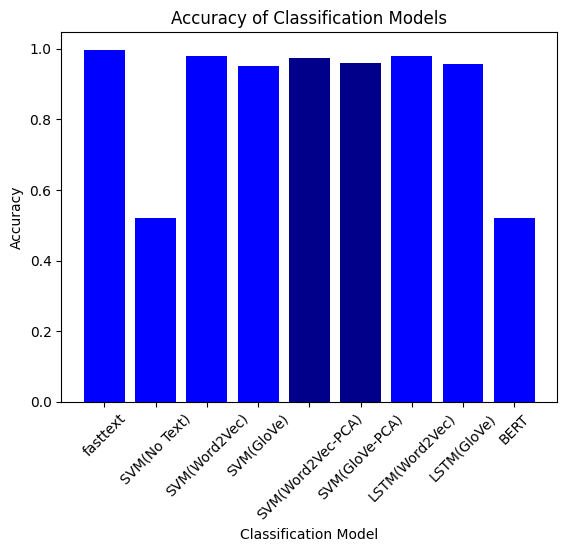

In [ ]:
import matplotlib.pyplot as plt

# Accuracy data
accuracy = [fasttext_accuracy[1], SVM_noText_accuracy, SVM_W2V_accuracy, SVM_GV_accuracy, SVM_W2V_PCA_accuracy, SVM_GV_PCA_accuracy, LSTM_W2V_accuracy, LSTM_GV_accuracy, 0.5209400757406994] 

# Classification model names
model_names = ['fasttext', 'SVM(No Text)', 'SVM(Word2Vec)', 'SVM(GloVe)', 'SVM(Word2Vec-PCA)', 'SVM(GloVe-PCA)', 'LSTM(Word2Vec)', 'LSTM(GloVe)', 'BERT']
colors = ['Blue', 'blue', 'blue', 'blue', 'DarkBlue', 'DarkBlue', 'blue', 'blue', 'blue']
# Bar chart
plt.bar(model_names, accuracy, color=colors)
plt.xticks(rotation=45)
plt.xlabel('Classification Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Classification Models')

# Display the chart
plt.show()


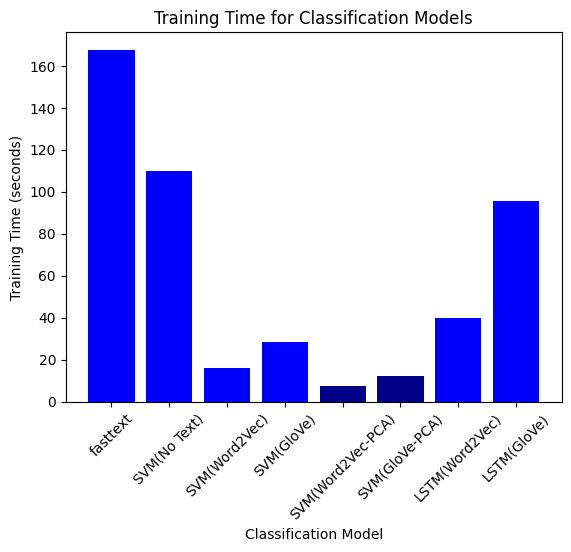

In [ ]:
# Training time data
training_time = [fasttext_training_time, SVM_noText_training_time, SVM_Text_W2V_training_time, SVM_Text_GV_training_time, SVM_Text_W2V_PCA_training_time, SVM_Text_GV_PCA_training_time, LSTM_W2V_training_time, LSTM_GV_training_time]

# Classification model names
model_names = ['fasttext', 'SVM(No Text)', 'SVM(Word2Vec)', 'SVM(GloVe)', 'SVM(Word2Vec-PCA)', 'SVM(GloVe-PCA)', 'LSTM(Word2Vec)', 'LSTM(GloVe)'] 

colors = ['Blue', 'blue', 'blue', 'blue', 'DarkBlue', 'DarkBlue', 'blue', 'blue']
# Bar chart
plt.bar(model_names, training_time, color=colors)
plt.xticks(rotation=45)
plt.xlabel('Classification Model')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Classification Models')

# Display the chart
plt.show()

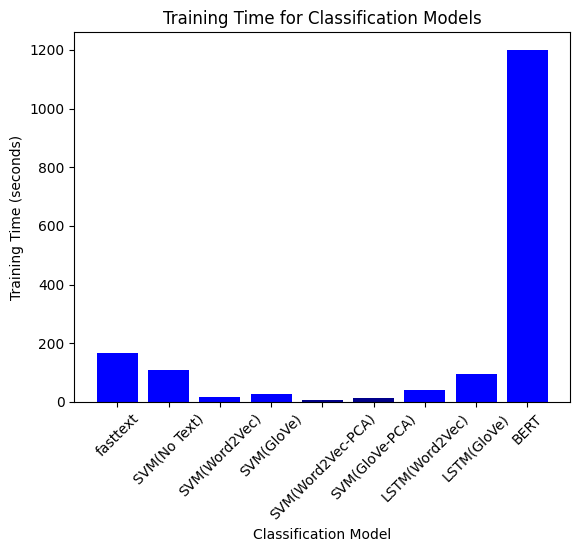

In [ ]:
# Training time data
training_time = [fasttext_training_time, SVM_noText_training_time, SVM_Text_W2V_training_time, SVM_Text_GV_training_time, SVM_Text_W2V_PCA_training_time, SVM_Text_GV_PCA_training_time, LSTM_W2V_training_time, LSTM_GV_training_time, 1200] 

# Classification model names
model_names = ['fasttext', 'SVM(No Text)', 'SVM(Word2Vec)', 'SVM(GloVe)', 'SVM(Word2Vec-PCA)', 'SVM(GloVe-PCA)', 'LSTM(Word2Vec)', 'LSTM(GloVe)', 'BERT'] 

colors = ['Blue', 'blue', 'blue', 'blue', 'DarkBlue', 'DarkBlue', 'blue', 'blue', 'blue']
# Bar chart
plt.bar(model_names, training_time, color=colors)
plt.xticks(rotation=45)
plt.xlabel('Classification Model')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Classification Models')

# Display the chart
plt.show()

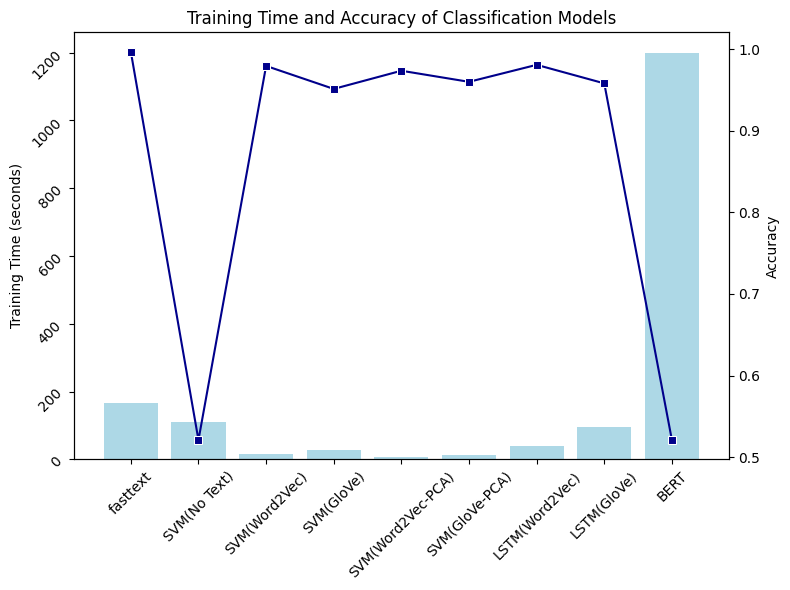

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plotting the bar chart for training time
ax1.bar(model_names, training_time, color='lightblue')
ax1.set_ylabel('Training Time (seconds)')
ax1.set_title('Training Time and Accuracy of Classification Models')
ax2 = ax1.twinx()

sns.lineplot(x=model_names, y=accuracy, marker='s', color='darkblue', ax=ax2)
ax2.set_ylabel('Accuracy')

ax1.tick_params(rotation=45)

fig.tight_layout()
plt.show()

## Discussion
* 從圖片中可以發現，fasttext效果最好，但是他的訓練時間偏長
* 這個數據集中，一定要用text資料才可以做出比較好的分類，單純使用其他columns做分類，效果很差。
* 其他columns的數據分別是時間、新聞主題，SVM只收這些當input data 的text accuracy只有差不多0.5，因此我們推論，不論時間，也不論任何主題，都有可能會有假新聞。
* 從PCA後的分類模型結果來看，不管用SVM or LSTM分類效果都還是不受影響，因此可以推論，也許可以不用建立維度這麼大的字典，也可以有不錯的word embedding效果。